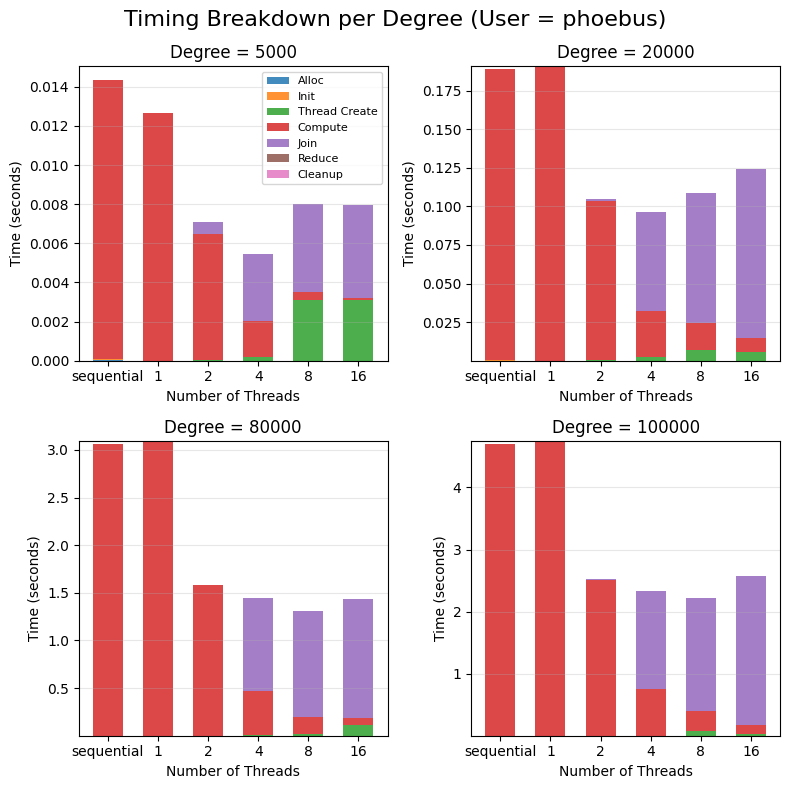

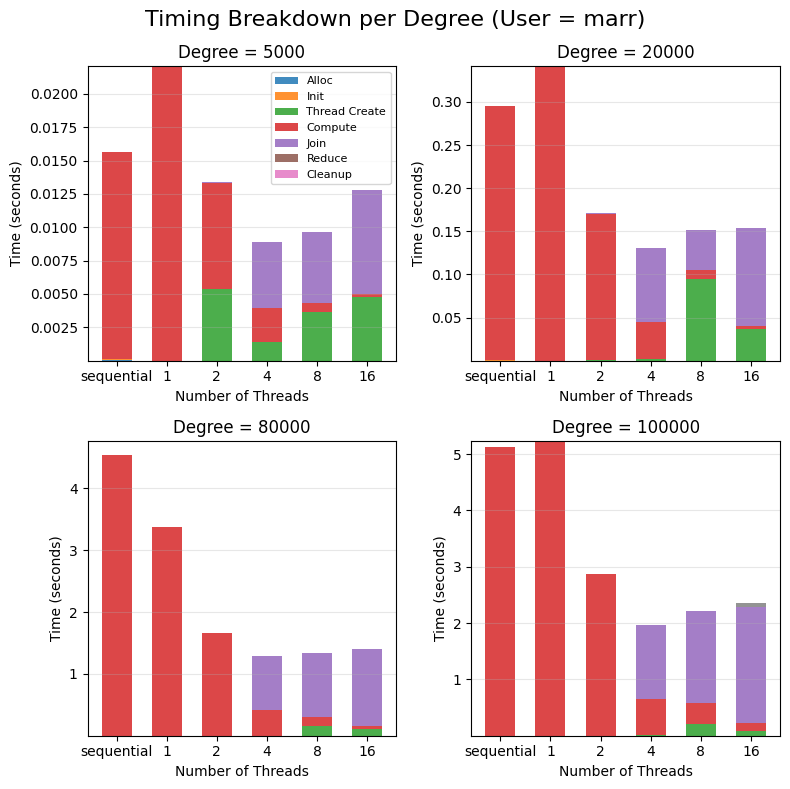

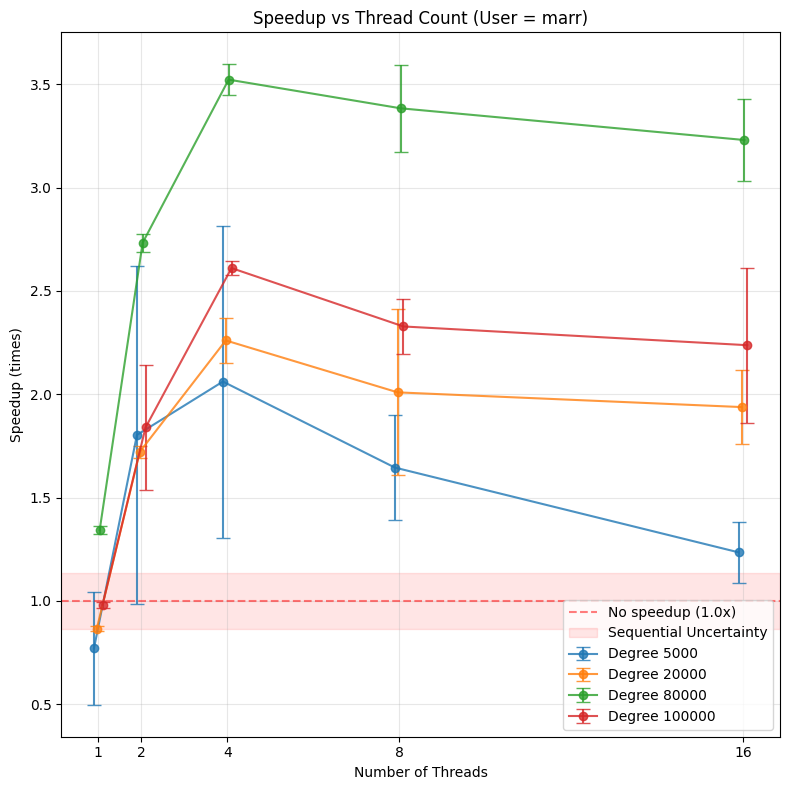

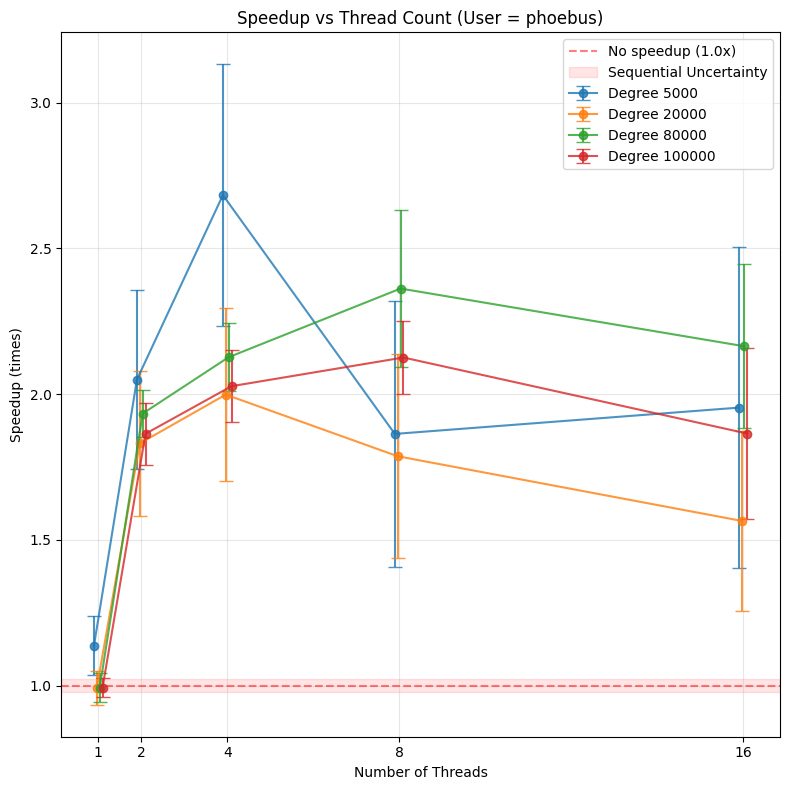

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

component_labels = {
    'time_alloc': 'Alloc', 'time_init': 'Init', 'time_thread_create': 'Thread Create',
    'time_compute': 'Compute', 'time_join': 'Join',
    'time_cleanup': 'Cleanup'
}

res_1_df = pd.read_csv('results_3.1.csv')
os.makedirs('plots', exist_ok=True)

for selected_user in res_1_df['user'].unique():
    user_data = res_1_df[res_1_df['user'] == selected_user]
    degrees = sorted(user_data['degree'].unique())
    
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    axes = axes.flatten()
    
    for idx, degree in enumerate(degrees):
        degree_data = user_data[user_data['degree'] == degree].copy()
        
        degree_data['effective_total'] = degree_data['time_total'] - degree_data['time_verify']
        example_data = degree_data.groupby('threads').mean(numeric_only=True).reset_index()
        
        example_data['threads_sort'] = example_data['threads'].apply(
            lambda x: -1 if x == 'sequential' else int(x)
        )
        example_data = example_data.sort_values('threads_sort').reset_index(drop=True)
        
        ax = axes[idx]
        x_positions = np.arange(len(example_data))
        
        bottom = np.zeros(len(example_data))
        available_components = [c for c in component_labels if c in example_data.columns]
        
        for component in available_components:
            values = example_data[component].values
            label = component_labels[component] if np.max(values) > 1e-6 else None
            ax.bar(x_positions, values, bottom=bottom, label=label, 
                   alpha=0.85, width=0.6)
            bottom += values
        
        components_sum = example_data[available_components].sum(axis=1).values
        remaining = example_data['effective_total'].values - components_sum
        
        if np.any(remaining > 0.001):
            ax.bar(x_positions, remaining, bottom=bottom, label='Other/Overhead', 
                   alpha=0.85, width=0.6, color='gray')
        
        ax.set_xlabel('Number of Threads')
        ax.set_ylabel('Time (seconds)')
        ax.set_title(f'Degree = {int(degree)}')
        ax.set_xticks(x_positions)
        ax.set_xticklabels(example_data['threads'])
        if idx == 0:
            ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3, axis='y')
    
    fig.suptitle(f'Timing Breakdown per Degree (User = {selected_user})', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'plots/timing_breakdown_all_degrees_{selected_user}.png', dpi=300)
    plt.show()

sequential_data = res_1_df[res_1_df['threads'] == 'sequential']
baselines = sequential_data.groupby(['user', 'degree'])['time_total'].agg(['mean', 'std']).reset_index()
baselines.columns = ['user', 'degree', 'baseline_mean', 'baseline_std']

parallel_data = res_1_df[res_1_df['threads'] != 'sequential'].copy()
parallel_data['par_time'] = parallel_data['time_total'] - parallel_data['time_verify']
parallel_data['threads'] = parallel_data['threads'].astype(int)

speedup_data = parallel_data.merge(baselines, on=['user', 'degree'])
speedup_data['speedup'] = speedup_data['baseline_mean'] / speedup_data['par_time']
speedup_data = speedup_data[['user', 'degree', 'threads', 'speedup']]

speedup_stats = speedup_data.groupby(['user', 'degree', 'threads'])['speedup'].agg(['mean', 'std']).reset_index()

for user in speedup_stats['user'].unique():
    user_stats = speedup_stats[speedup_stats['user'] == user]
    user_baselines = baselines[baselines['user'] == user]
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    degrees = sorted(user_stats['degree'].unique())
    jitter = np.linspace(-0.1, 0.1, len(degrees))
    
    for idx, degree in enumerate(degrees):
        degree_data = user_stats[user_stats['degree'] == degree]
        x_jitter = degree_data['threads'] + jitter[idx]
        ax.errorbar(x_jitter, degree_data['mean'], yerr=degree_data['std'],
                    marker='o', label=f'Degree {int(degree)}', capsize=5, alpha=0.8)
    
    ax.axhline(y=1.0, color='r', linestyle='--', alpha=0.5, label='No speedup (1.0x)')
    
    baseline_uncertainty = user_baselines['baseline_std'].mean() / user_baselines['baseline_mean'].mean()
    ax.axhspan(1.0 - baseline_uncertainty, 1.0 + baseline_uncertainty, 
               color='red', alpha=0.1, label='Sequential Uncertainty')
    
    ax.set_xlabel('Number of Threads')
    ax.set_ylabel('Speedup (times)')
    ax.set_title(f'Speedup vs Thread Count (User = {user})')
    ax.set_xticks(sorted(user_stats['threads'].unique()))
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.savefig(f'plots/speedup_per_degree_{user}.png', dpi=300)
    plt.show()
